In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.utils as vutils
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
import random
from utils import *

In [ ]:
seed = 1234
random.seed(seed)
torch.manual_seed(seed)
print("Random Seed: ", seed)

Random Seed:  1234


In [ ]:
# Use GPU if available.
device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")
print(device, " will be used.\n")

cpu  will be used.



In [ ]:
# Dictionary for storing NN parameters.
params = {
    'batch_size': 128,# Batch size.
    'num_epochs': 50,# Number of epochs to train for.
    'learning_rate': 2e-4,# Learning rate.
    'beta1': 0.5,
    'beta2': 0.999,
    'save_epoch' : 50,# After how many epochs to save checkpoints and generate test output.
    'dataset' : 'CelebA'}

#Models

In [ ]:
Generator = nn.Sequential(nn.ConvTranspose2d(228,448,2,1,bias=False),
                          nn.BatchNorm2d(448),
                          nn.ReLU(),
                          nn.ConvTranspose2d(448,256,4,2,padding=1,bias=False),
                          nn.BatchNorm2d(256),
                          nn.ReLU(),
                          nn.ConvTranspose2d(256, 128, 4, 2, padding=1, bias=False),
                          nn.ReLU(),
                          nn.ConvTranspose2d(128, 64, 4, 2, padding=1, bias=False),
                          nn.ReLU(),
                          nn.ConvTranspose2d(64, 3, 4, 2, padding=1, bias=False),
                          nn.Tanh()
    
)

Discriminator = nn.Sequential(nn.Conv2d(3,64,4,2,1),
                              nn.LeakyReLU(inplace=True),
                              nn.Conv2d(64,128,4,2,1,bias=False),
                              nn.BatchNorm2d(128),
                              nn.LeakyReLU(inplace=True),
                              nn.Conv2d(128,256,4,2,1,bias=False),
                              nn.BatchNorm2d(256),
                              nn.LeakyReLU(inplace=True),
    
)

In [ ]:
#The Q distribution as a neural network, taken from someone else

class DHead(nn.Module):
	def __init__(self):
		super().__init__()
		self.conv = nn.Conv2d(256, 1, 4)
  
	def forward(self, x):
		output = torch.sigmoid(self.conv(x))
		return output

class QHead(nn.Module):
	def __init__(self):
		super().__init__()
		self.conv1 = nn.Conv2d(256, 128, 4, bias=False)
		self.bn1 = nn.BatchNorm2d(128)
		self.conv_disc = nn.Conv2d(128, 100, 1)
		self.conv_mu = nn.Conv2d(128, 1, 1)
		self.conv_var = nn.Conv2d(128, 1, 1)

	def forward(self, x):
		x = F.leaky_relu(self.bn1(self.conv1(x)), 0.1, inplace=True)
		disc_logits = self.conv_disc(x).squeeze()
		# Not used during training for celeba dataset.
		mu = self.conv_mu(x).squeeze()
		var = torch.exp(self.conv_var(x).squeeze())
		return disc_logits, mu, var


#Dataloading
Here we first download or load the data and then extract into a folder with images

In [ ]:
root = '/content/data/'
transform = transforms.Compose([
            transforms.Resize(32),
            transforms.CenterCrop(32),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5),
                (0.5, 0.5, 0.5))])

#If not yet downloaded then
#dataset = dsets.CelebA(root='/content/data', split='train',transform=transform, download=True)

#If downloaded manually then just load
from zipfile import ZipFile 
file_name = "img_align_celeba.zip"
  
with ZipFile(file_name, 'r') as zip: 
    zip.extractall() 
    print('Done!') 


Done!


In [ ]:
#Read the images and create data loader object
dataset = dsets.ImageFolder('/content/data/celeba/imgs', transform=transform)


dataloader = torch.utils.data.DataLoader(dataset, batch_size=params['batch_size'], shuffle=True)

NameError: ignored

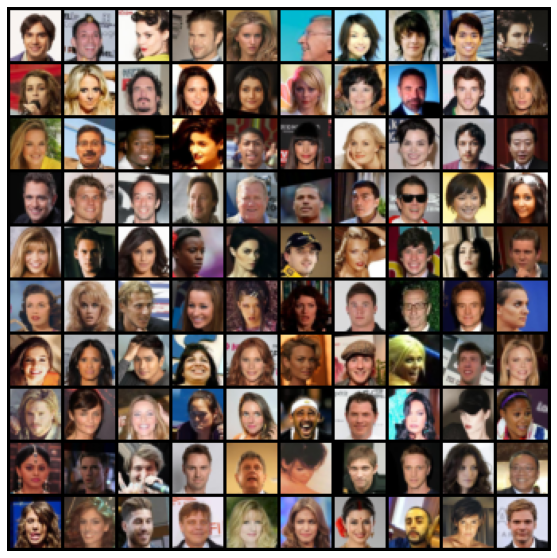

In [ ]:
# Plot some of the training images.
sample_batch = next(iter(dataloader))
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(sample_batch[0].to(device)[ : 100], nrow=10, padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.savefig('Training Images {}'.format(params['dataset']))
plt.show()
plt.close('all')

In [ ]:
# Initialise the network by initializing the weights and sending to GPU if available
netG = Generator.to(device)
discriminator = Discriminator.to(device)
netD = DHead().to(device)
netQ = QHead().to(device)


netG.apply(weights_init)
discriminator.apply(weights_init)
netD.apply(weights_init)
netQ.apply(weights_init)


In [ ]:
# Set appropriate hyperparameters depending on the dataset used. FOr the the CelebA dataset they recommended to use the afore mentioned ones in the paper

# num_z : dimension of incompressible noise.
# num_con_c : number of continuous latent code used.
# num_dis_c : number of discrete latent code used.
# dis_c_dim : dimension of discrete latent code.

params['num_z'] = 128
params['num_con_c'] = 0
params['num_dis_c'] = 10
params['dis_c_dim'] = 10

#Training

In [ ]:
# Loss for discrimination between real and fake images.
criterionD = nn.BCELoss()
# Loss for discrete latent code.
criterionQ_dis = nn.CrossEntropyLoss()
# Loss for continuous latent code.
criterionQ_con = NormalNLLLoss()

# Adam optimiser is used.
optimD = optim.Adam([{'params': discriminator.parameters()}, {'params': netD.parameters()}], lr=params['learning_rate'], betas=(params['beta1'], params['beta2']))
optimG = optim.Adam([{'params': netG.parameters()}, {'params': netQ.parameters()}], lr=params['learning_rate'], betas=(params['beta1'], params['beta2']))

# Fixed Noise
z = torch.randn(100, params['num_z'], 1, 1, device=device)
fixed_noise = z
if(params['num_dis_c'] != 0):
    idx = np.arange(params['dis_c_dim']).repeat(10)
    dis_c = torch.zeros(100, params['num_dis_c'], params['dis_c_dim'], device=device)
    for i in range(params['num_dis_c']):
        dis_c[torch.arange(0, 100), i, idx] = 1.0

    dis_c = dis_c.view(100, -1, 1, 1)

    fixed_noise = torch.cat((fixed_noise, dis_c), dim=1)

if(params['num_con_c'] != 0):
    con_c = torch.rand(100, params['num_con_c'], 1, 1, device=device) * 2 - 1
    fixed_noise = torch.cat((fixed_noise, con_c), dim=1)

real_label = 1
fake_label = 0
img_list = []
G_losses = []
D_losses = []

-------------------------
Starting Training Loop...

Epochs: 1
Dataset: CelebA
Batch Size: 128
Length of Data Loader: 1583
-------------------------


In [ ]:
print("-"*25)
print("Starting Training ...\n")
print('Epochs: %d\nDataset: {}\nBatch Size: %d\nLength of Data Loader: %d'.format(params['dataset']) % (params['num_epochs'], params['batch_size'], len(dataloader)))
print("-"*25)

start_time = time.time()
iters = 0

for epoch in range(params['num_epochs']):
    epoch_start_time = time.time()

    for i, (data, _) in enumerate(dataloader, 0):
        # Get batch size
        b_size = data.size(0)
        # Transfer data tensor to GPU if its availble
        real_data = data.to(device)

        # Updating discriminator and DHead
        optimD.zero_grad()
        # Real data
        label = torch.full((b_size, ), real_label, device=device,dtype=torch.float32)
        output1 = discriminator(real_data)
        probs_real = netD(output1).view(-1)
        loss_real = criterionD(probs_real, label)
      
        # Fake data
        label.fill_(fake_label)
        noise, idx = noise_sample(params['num_dis_c'], params['dis_c_dim'], params['num_con_c'], params['num_z'], b_size, device)
        fake_data = netG(noise)
        output2 = discriminator(fake_data.detach())
        probs_fake = netD(output2).view(-1)
        loss_fake = criterionD(probs_fake, label)
        # Calculate gradients.
        loss_real.backward()
        loss_fake.backward()

        # Net Loss for the discriminator, simply the sum
        D_loss = loss_real + loss_fake
        # Update parameters, G and QHead
        optimD.step()
        optimG.zero_grad()

        # This is for the Fake data to be treated as real.
        #They had this previously in another implementation
        output = discriminator(fake_data)
        label.fill_(real_label)
        probs_fake = netD(output).view(-1)
        gen_loss = criterionD(probs_fake, label)
        q_logits,q_mu, q_var = netQ(output)
        
        target = torch.LongTensor(idx).to(device)

        # Calculating loss for discrete latent code.
        dis_loss = 0
        for j in range(params['num_dis_c']):
            dis_loss += criterionQ_dis(q_logits[:, j*10 : j*10 + 10], target[j])

        # Calculating loss for continuous latent code.
        con_loss = 0
        if (params['num_con_c'] != 0):
            con_loss = criterionQ_con(noise[:, params['num_z']+ params['num_dis_c']*params['dis_c_dim'] : ].view(-1, params['num_con_c']), q_mu, q_var)*0.1

        # Net loss for generator.
        G_loss = gen_loss + dis_loss + con_loss
        # Calculate gradients.
        G_loss.backward()
        # Update parameters.
        optimG.step()

        # Check progress of training.
        if i != 0 and i%100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch+1, params['num_epochs'], i, len(dataloader), 
                    D_loss.item(), G_loss.item()))

        # Save the losses for plotting.
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())

        iters += 1

    epoch_time = time.time() - epoch_start_time
    print("Time taken for Epoch %d: %.2fs" %(epoch + 1, epoch_time))
    # Generate image after each epoch to check performance of the generator. Used for creating animated gif later.
    with torch.no_grad():
        gen_data = netG(fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True))

    # Generate image to check performance of generator.
    if((epoch+1) == 1 or (epoch+1) == params['num_epochs']/2):
        with torch.no_grad():
            gen_data = netG(fixed_noise).detach().cpu()
        plt.figure(figsize=(10, 10))
        plt.axis("off")
        plt.imshow(np.transpose(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True), (1,2,0)))
        plt.savefig("Epoch_%d {}".format(params['dataset']) %(epoch+1))
        plt.close('all')

    # Save network weights.
    if (epoch+1) % params['save_epoch'] == 0:
        torch.save({
            'netG' : netG.state_dict(),
            'discriminator' : discriminator.state_dict(),
            'netD' : netD.state_dict(),
            'netQ' : netQ.state_dict(),
            'optimD' : optimD.state_dict(),
            'optimG' : optimG.state_dict(),
            'params' : params
            }, 'checkpoint/model_epoch_%d_{}'.format(params['dataset']) %(epoch+1))

training_time = time.time() - start_time
print("-"*50)
print('Training finished!\nTotal Time for Training: %.2fm' %(training_time / 60))
print("-"*50)


cpu  will be used.

[1/1][100/1583]	Loss_D: 0.0075	Loss_G: 30.6786
[1/1][200/1583]	Loss_D: 0.0076	Loss_G: 29.6436
[1/1][300/1583]	Loss_D: 0.0078	Loss_G: 28.8995
[1/1][400/1583]	Loss_D: 0.0140	Loss_G: 29.4953
[1/1][500/1583]	Loss_D: 0.0285	Loss_G: 27.6668
[1/1][600/1583]	Loss_D: 0.0194	Loss_G: 26.4317
[1/1][700/1583]	Loss_D: 0.0295	Loss_G: 26.9150
[1/1][800/1583]	Loss_D: 0.1811	Loss_G: 25.7078
[1/1][900/1583]	Loss_D: 0.3265	Loss_G: 27.0278
[1/1][1000/1583]	Loss_D: 0.0892	Loss_G: 25.8979
[1/1][1100/1583]	Loss_D: 0.3138	Loss_G: 25.0291
[1/1][1200/1583]	Loss_D: 0.3023	Loss_G: 26.0264
[1/1][1300/1583]	Loss_D: 0.2770	Loss_G: 23.7741
[1/1][1400/1583]	Loss_D: 0.2564	Loss_G: 24.3689
[1/1][1500/1583]	Loss_D: 0.2818	Loss_G: 24.7442
Time taken for Epoch 1: 3350.63s
--------------------------------------------------
Training finished!
Total Time for Training: 55.86m
--------------------------------------------------


In [ ]:
from matplotlib.animation import ImageMagickWriter

In [ ]:

# Generate image to check performance of trained generator.
with torch.no_grad():
    gen_data = netG(fixed_noise).detach().cpu()
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True), (1,2,0)))
plt.savefig("Epoch_%d_{}".format(params['dataset']) %(params['num_epochs']))

# Save network weights.
torch.save({
    'netG' : netG.state_dict(),
    'discriminator' : discriminator.state_dict(),
    'netD' : netD.state_dict(),
    'netQ' : netQ.state_dict(),
    'optimD' : optimD.state_dict(),
    'optimG' : optimG.state_dict(),
    'params' : params
    }, 'checkpoint/model_final_{}'.format(params['dataset']))


# Plot the training losses.
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig("Loss Curve {}".format(params['dataset']))

# Animation showing the improvements of the generator.
fig = plt.figure(figsize=(10,10))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
anim = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
anim.save('infoGAN_{}.gif'.format(params['dataset']), dpi=80, writer='imagemagick')
plt.show()